In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import numpy as np
import pandas as pd

traffic_df = pd.read_csv('/content/gdrive/MyDrive/CIC-Darknet/darknet_log.csv')
traffic_df.shape

(141481, 80)

### Drop Columns

In [3]:
drop_columns = [2, 5, 8, 9, 10, 12, 13, 14, 15, 18, 19, 23, 24, 25, 28, 32, 33, 34, 35, 37, 40, 41, 42, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 76]
traffic_df.drop(traffic_df.columns[drop_columns], axis=1 ,inplace=True)
traffic_df.head()

,Src Port,Dst Port,Flow Duration,Total Fwd Packet,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Max,...,Packet Length Std,PSH Flag Count,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,FWD Init Win Bytes,Bwd Init Win Bytes,Idle Mean,Idle Max,Idle Min,target
0,57158,443,229,1,0,0,0.000,0.000000,9.075050,229,...,0.00,0,0,0,1892,1047,0.000000,0.000000,0.000000,0
1,57159,443,407,1,0,0,0.000,0.000000,8.500048,407,...,0.00,0,0,0,1987,1047,0.000000,0.000000,0.000000,0
2,57160,443,431,1,0,0,0.000,0.000000,8.442765,431,...,0.00,0,0,0,2049,1047,0.000000,0.000000,0.000000,0
3,49134,443,359,1,0,0,0.000,0.000000,8.625515,359,...,0.00,0,0,0,2008,1047,0.000000,0.000000,0.000000,0
4,34697,19305,10778451,591,64530,6659,3.148,8.795696,4.531983,78158,...,4.06,659,659,6605,1382,2320,34.901863,34.901863,34.901863,0


### Data Split

In [4]:
from sklearn.model_selection import train_test_split

y_traffic_df = traffic_df['target']
X_traffic_df = traffic_df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_traffic_df, y_traffic_df, stratify=y_traffic_df, test_size=0.4, random_state=11)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(84888, 29) (84888,)
(56593, 29) (56593,)


In [5]:
X_vali, X_test, y_vali, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=11)
print(X_vali.shape, y_vali.shape)
print(X_test.shape, y_test.shape)

(28296, 29) (28296,)
(28297, 29) (28297,)


### Repredict

##### train_df

In [6]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train
train_df.shape

(84888, 30)

### Benign Voip, Darknet Voip

##### train

In [7]:
benign_voip = train_df['target'] == 6
darknet_voip = train_df['target'] == 14

retrain_label = benign_voip | darknet_voip
retrain_df = train_df[retrain_label]
print(retrain_df['target'].value_counts())
print(retrain_df.shape)

6     1261
14     879
Name: target, dtype: int64
(2140, 30)


In [8]:
y_train2 = retrain_df['target']
X_train2 = retrain_df.drop('target', axis=1)
print(X_train2.shape, y_train2.shape)

(2140, 29) (2140,)


In [9]:
X_train2 = pd.DataFrame(X_train2)
X_train2.reset_index(drop=True, inplace=True)

In [10]:
y_train2 = pd.DataFrame(y_train2)
y_train2.reset_index(drop=True, inplace=True)

In [11]:
from sklearn.manifold import TSNE

# 2차원 t-SNE 임베딩
tsne_np = TSNE(n_components = 2).fit_transform(X_train2)

# numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


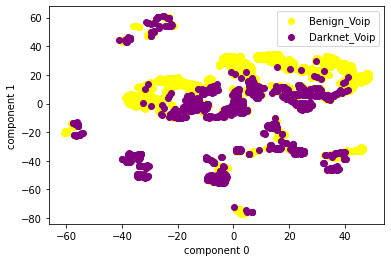

In [12]:
import matplotlib.pyplot as plt

# class target 정보 불러오기 
tsne_df['target'] = np.array(y_train2)

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 6]
tsne_df_1 = tsne_df[tsne_df['target'] == 14]

# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'yellow', label = 'Benign_Voip')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = 'Darknet_Voip')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()